In [1]:
from torchvision.datasets import Cityscapes

import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys

2.1.2


In [2]:
print('__Python VERSION: ', sys.version)
print('__PyTorch VERSION: ', torch.__version__)
print('__CUDA VERSION', )
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print('Available devices ', torch.cuda.device_count())
print('Current cuda device ', torch.cuda.current_device())

__Python VERSION:  3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
__PyTorch VERSION:  2.1.2
__CUDA VERSION
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [3]:
# Check if GPU is avaliable on your system
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

Training on cuda


In [4]:
import torchvision.transforms as transforms

# Define the transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Resize((256,256),antialias=True)
])
dataset_path = 'C:\\Users\\jakub\\Desktop\\TUe\\AIES\\Q3\\5LSM0-Neural-networks-for-computer-vision\\FinalAssignment\\archive'

# Create the untransformed dataset
original_dataset = Cityscapes(dataset_path, split='train', mode='fine', target_type='semantic', transform=None, target_transform=None)

# Create transformed train dataset
training_dataset = Cityscapes(dataset_path, split='train', mode='fine', target_type='semantic', transform=data_transforms, target_transform=data_transforms)

# Create transformed train dataset
validation_dataset = Cityscapes(dataset_path, split='val', mode='fine', target_type='semantic', transform=data_transforms, target_transform=data_transforms)

In [5]:
# Extract info about the original dataset
num_images_original = len(original_dataset)
image_original, _ = original_dataset[0]
image_size_original = image_original.width, image_original.height
num_classes_original = original_dataset.classes

# Extract info about the transformed training dataset
train_num_images = len(training_dataset)
train_image_size = training_dataset[0][0].size()
train_num_classes = training_dataset.classes

# Extract info about the transformed validation dataset
val_num_images = len(validation_dataset)
val_image_size = validation_dataset[0][0].size()
val_num_classes = validation_dataset.classes

# Create and open a text file
with open('dataset_info.txt', 'w') as file:
    # Transformed training dataset info
    file.write("Training Dataset state after transform:\n")
    file.write(f"Number of images: {train_num_images}\n")
    file.write(f"Image size: {train_image_size}\n")
    file.write(f"Number of classes: {train_num_classes}\n")
    # Transformed validation dataset info
    file.write("\n")
    file.write("Validation Dataset state after transform:\n")
    file.write(f"Number of images: {val_num_images}\n")
    file.write(f"Image size: {val_image_size}\n")
    file.write(f"Number of classes: {val_num_classes}\n")

print("Dataset state BEFORE transform:\n")
print("Number of samples:", len(original_dataset))
print("Classes:", original_dataset.classes)
print("Image size after applying transforms:", image_size_original, "\n")
print("Dataset info AFTER applying the transforms:\n")
print("Number of samples:", len(training_dataset))
print("Classes:", training_dataset.classes)
print("Image size after applying transforms:", train_image_size)
print("\n")
print("Number of samples:", len(validation_dataset))
print("Classes:", validation_dataset.classes)
print("Image size after applying transforms:", val_image_size)



Dataset state BEFORE transform:

Number of samples: 2975
Classes: [CityscapesClass(name='unlabeled', id=0, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='ego vehicle', id=1, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='rectification border', id=2, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='out of roi', id=3, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='static', id=4, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)), CityscapesClass(name='dynamic', id=5, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(111, 74, 0)), CityscapesClass(name='ground', id=6, train_id

In [6]:
# Access all class names in the original dataset
all_class_names = [cityscapes_class.name for cityscapes_class in training_dataset.classes]

# Print all class names
print("All Class Names:")
print(all_class_names)
print(len(all_class_names))


All Class Names:
['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']
35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


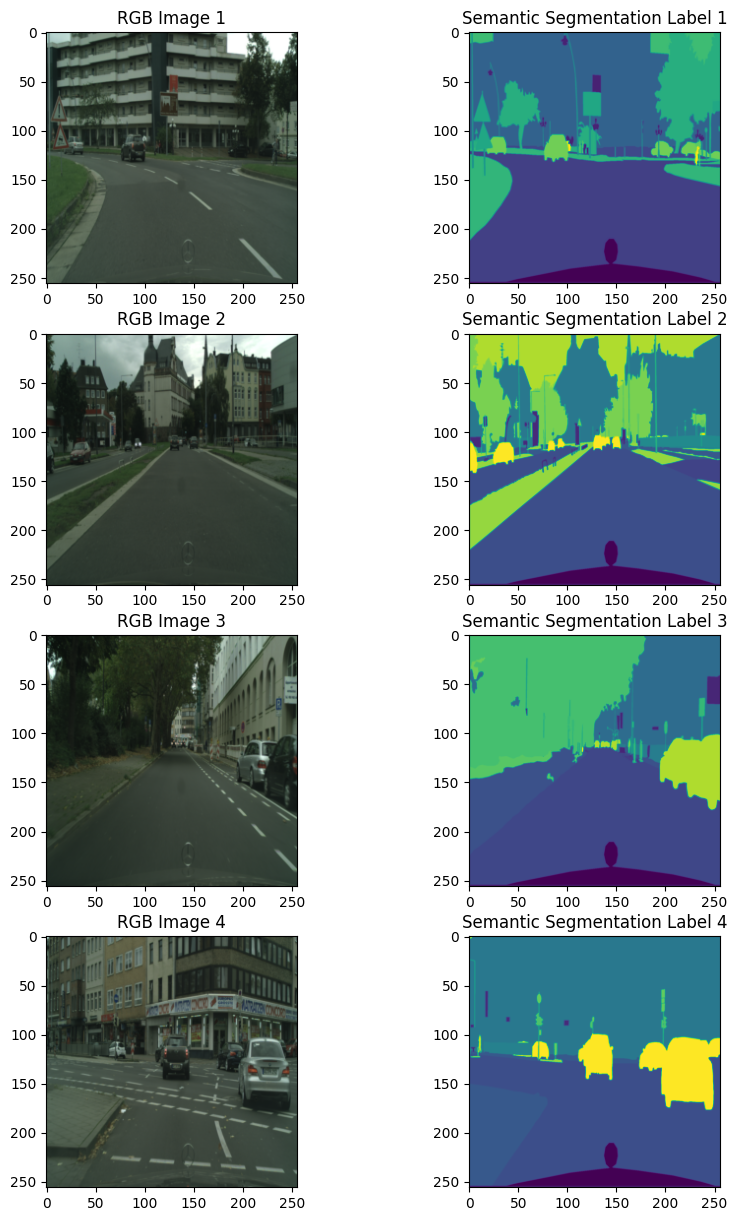

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i in range(4):
    # TO DO: spec the fig size
    img, lbl = training_dataset[i]

    img_np = img.permute(1, 2, 0)
    lbl_np = lbl.permute(1, 2, 0)

    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(img_np)
    plt.title(f'RGB Image {i+1}')

    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(lbl_np)  # Adjust the colormap as needed
    plt.title(f'Semantic Segmentation Label {i+1}')

# Adjust layout to prevent overlap
# plt.tight_layout()
    
# Save a figure to a PNG format file
plt.savefig('Cityspace-test-vis.png')

plt.show()

In [8]:
# Create training and validation dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=2,
                                            pin_memory=True if torch.cuda.is_available() else False)

val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10, shuffle=True, num_workers=2,
                                            pin_memory=True if torch.cuda.is_available() else False)


In [9]:
# # Print the device of the first batch from the training dataloader
# for inputs, masks in train_loader:
#     inputs, masks = inputs.to(device), masks.to(device)
#     print("Training Data - Device:", inputs.device)
#     break  # Print only the first batch

# # Print the device of the first batch from the validation dataloader
# for val_inputs, val_masks in val_loader:
#     val_inputs, val_masks = val_inputs.to(device), val_masks.to(device)
#     print("Validation Data - Device:", val_inputs.device)
#     break  # Print only the first batch

## Training Model

In [10]:
# from model import Model
# from model_executables import train_model_noval

# # Instanciate the model
# UNet_model = Model()

# # Move the model to the GPU if avaliable
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# UNet_model = UNet_model.to(device)

# # Train the instanciated model
# train_model_noval(model=UNet_model, train_loader=train_loader, num_epochs=2, lr=0.01, patience=4)


In [11]:
# Create a test dataset
# Create transformed train dataset
test_dataset = Cityscapes(dataset_path, split='test', mode='fine', target_type='semantic', transform=data_transforms, target_transform=data_transforms)
# Create a test data loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=2,
                                            pin_memory=True if torch.cuda.is_available() else False)

In [12]:
# import random

# Existing color coding for the first 35 classes
colors_cityscapes = {
    0: (179, 17, 75),
    1: (138, 187, 36),
    2: (138, 94, 28),
    3: (68, 193, 94),
    4: (0, 143, 21),
    5: (122, 210, 11),
    6: (120, 177, 17),
    7: (152, 2, 32),
    8: (173, 251, 20),
    9: (79, 45, 163),
    10: (95, 149, 240),
    11: (179, 195, 232),
    12: (205, 22, 174),
    13: (143, 112, 157),
    14: (120, 249, 119),
    15: (154, 100, 13),
    16: (17, 175, 253),
    17: (10, 18, 16),
    18: (67, 65, 54),
    19: (132, 94, 164),
    20: (205, 85, 169),
    21: (6, 242, 80),
    22: (45, 104, 119),
    23: (122, 163, 180),
    24: (81, 47, 145),
    25: (150, 168, 7),
    26: (6, 147, 255),
    27: (200, 55, 78),
    28: (208, 149, 214),
    29: (2, 241, 14),
    30: (12, 148, 250),
    31: (153, 181, 176),
    32: (92, 40, 146),
    33: (252, 53, 128),
    34: (80, 132, 172),
    255: (255, 255, 255)
}

# Class names for the first 35 classes
class_names_cityscapes = [
    'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk',
    'parking', 'rail track', 'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup',
    'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate','unlabeled'
]
# color_list = []
# # Generate random colors for the remaining classes (22 to 34)
# for i in range(len(class_names_cityscapes_updated)):
#     color_list.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

# # Print the updated color coding
# for idx, color in enumerate(color_list):
#     print(f"{idx}: {color}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


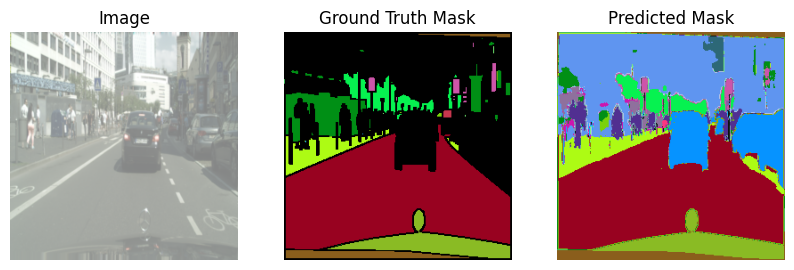

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


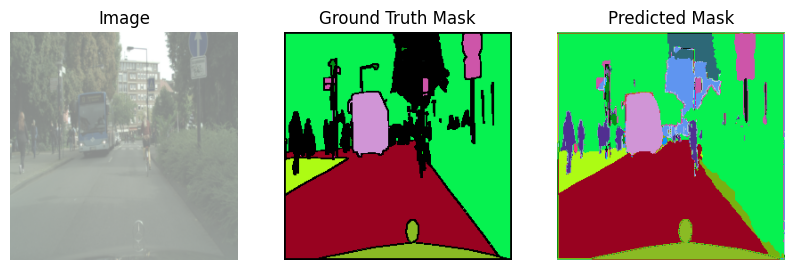

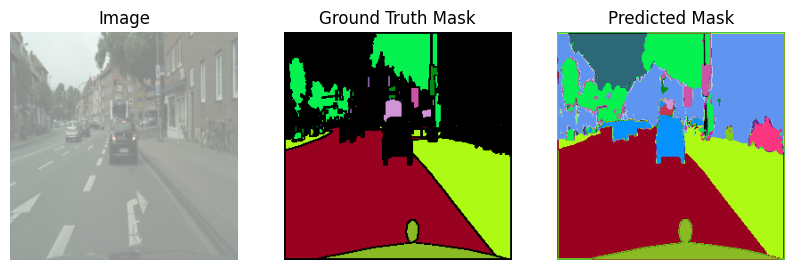

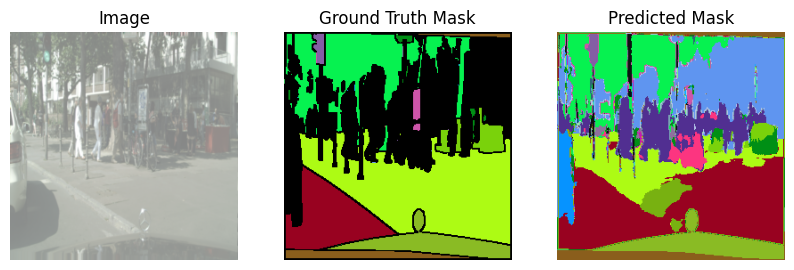

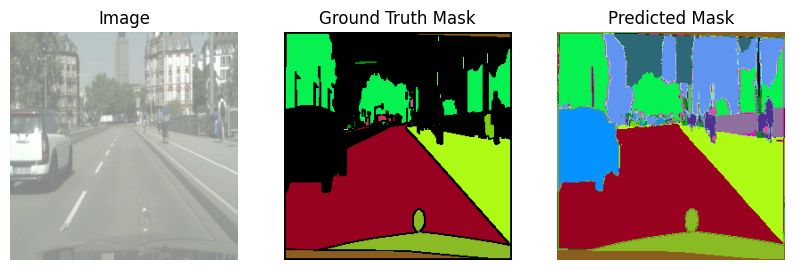

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


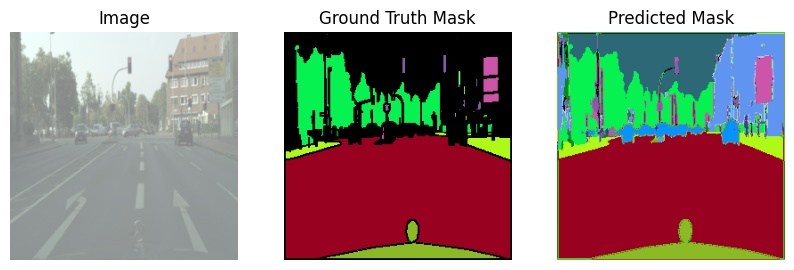

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


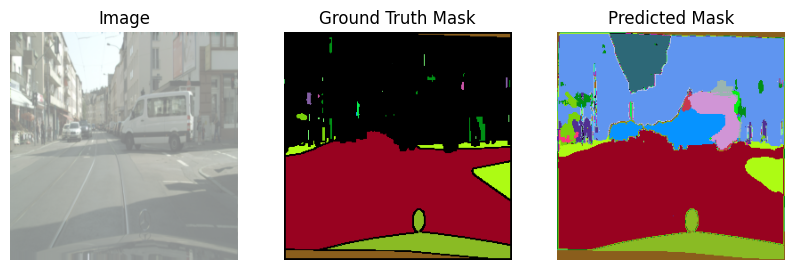

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


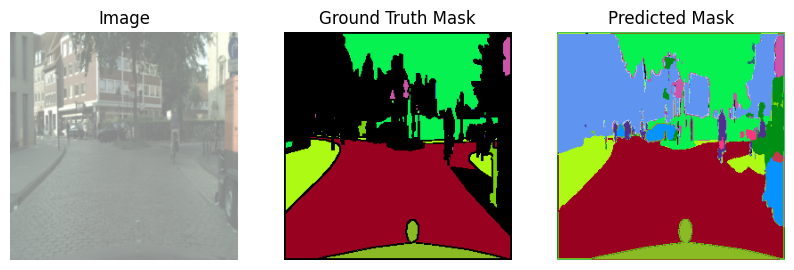

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


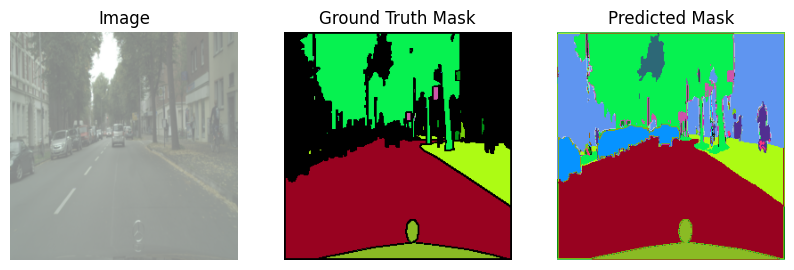

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


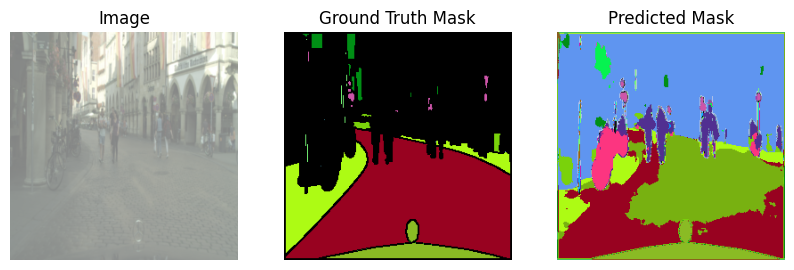

In [14]:
from model import Model
from model_vis import visualize_segmentation_cityscapes

# Instanciate Model()
eval_model = Model()

# Specify the checkpoint file path
checkpoint_path = 'C:\\Users\\jakub\\Desktop\\TUe\\AIES\\Q3\\5LSM0-Neural-networks-for-computer-vision\\FinalAssignment\\model_checkpoints\\model_checkpoint_epoch_50.pth'
device = torch.device('cpu') 

checkpoint = torch.load(checkpoint_path, map_location=device)
eval_model.load_state_dict(checkpoint['model_state_dict'])

# Call the function with the checkpoint path
visualize_segmentation_cityscapes(eval_model, val_loader, coloring=colors_cityscapes, num_examples=1)